In [1]:
!pip install pillow


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


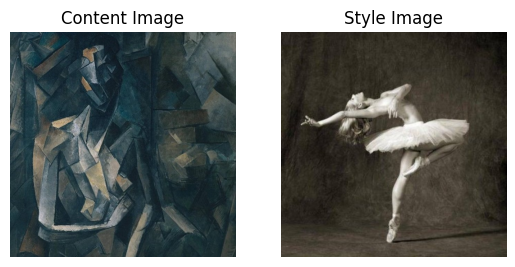

In [6]:
import requests
from io import BytesIO

# NEW working Content Image (girl with violin)
content_url = "https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg"
content_img = Image.open(BytesIO(requests.get(content_url).content)).convert('RGB')

# NEW working Style Image (Picasso painting)
style_url = "https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg"
style_img = Image.open(BytesIO(requests.get(style_url).content)).convert('RGB')

# Show both images
plt.subplot(1, 2, 1)
plt.title("Content Image")
plt.imshow(content_img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Style Image")
plt.imshow(style_img)
plt.axis("off")

plt.show()



In [7]:
imsize = 512  # Image size to resize both images

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()])

def image_loader(image):
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# Preprocess content and style images
content = image_loader(content_img)
style = image_loader(style_img)


In [8]:
from torchvision.models import vgg19

class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()
    def forward(self, x):
        self.loss = nn.functional.mse_loss(x, self.target)
        return x

class StyleLoss(nn.Module):
    def __init__(self, target_features):
        super().__init__()
        self.target = self.gram_matrix(target_features).detach()
    def gram_matrix(self, input):
        a, b, c, d = input.size()
        features = input.view(a * b, c * d)
        G = torch.mm(features, features.t())
        return G.div(a * b * c * d)
    def forward(self, x):
        G = self.gram_matrix(x)
        self.loss = nn.functional.mse_loss(G, self.target)
        return x

# Load pretrained VGG19 model
cnn = vgg19(pretrained=True).features.to(device).eval()

# Define content and style layers
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# Helper to create the model with loss functions
def get_model(cnn, style_img, content_img):
    model = nn.Sequential().to(device)
    content_losses = []
    style_losses = []

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f"conv_{i}"
        elif isinstance(layer, nn.ReLU):
            name = f"relu_{i}"
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f"pool_{i}"
        elif isinstance(layer, nn.BatchNorm2d):
            name = f"bn_{i}"
        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_losses.append(ContentLoss(target))
            model.add_module(f"content_loss_{i}", content_losses[-1])
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_losses.append(StyleLoss(target_feature))
            model.add_module(f"style_loss_{i}", style_losses[-1])

    return model, style_losses, content_losses


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 69.9MB/s]


In [9]:
input_img = content.clone()
model, style_losses, content_losses = get_model(cnn, style, content)
optimizer = optim.LBFGS([input_img.requires_grad_()])

run = [0]
while run[0] <= 50:
    def closure():
        input_img.data.clamp_(0, 1)
        optimizer.zero_grad()
        model(input_img)
        style_score = sum(sl.loss for sl in style_losses)
        content_score = sum(cl.loss for cl in content_losses)
        loss = style_score + content_score
        loss.backward()
        run[0] += 1
        return loss
    optimizer.step(closure)

# Clamp values to display correctly
input_img.data.clamp_(0, 1)


tensor([[[[0.1882, 0.1608, 0.1490,  ..., 0.3843, 0.3647, 0.3725],
          [0.1529, 0.1412, 0.1333,  ..., 0.3647, 0.3608, 0.3725],
          [0.1373, 0.1490, 0.1490,  ..., 0.3882, 0.3725, 0.3725],
          ...,
          [0.1451, 0.1608, 0.1647,  ..., 0.1333, 0.1373, 0.1373],
          [0.1451, 0.1647, 0.1725,  ..., 0.1294, 0.1294, 0.1255],
          [0.1490, 0.1765, 0.1804,  ..., 0.1294, 0.1176, 0.1137]],

         [[0.2667, 0.2392, 0.2275,  ..., 0.4157, 0.3961, 0.4039],
          [0.2314, 0.2196, 0.2118,  ..., 0.3961, 0.3882, 0.4000],
          [0.2157, 0.2275, 0.2275,  ..., 0.4196, 0.4000, 0.3961],
          ...,
          [0.2157, 0.2314, 0.2353,  ..., 0.1882, 0.1922, 0.1922],
          [0.2078, 0.2314, 0.2353,  ..., 0.1922, 0.1882, 0.1843],
          [0.2078, 0.2353, 0.2392,  ..., 0.1922, 0.1804, 0.1765]],

         [[0.2941, 0.2706, 0.2627,  ..., 0.3725, 0.3529, 0.3608],
          [0.2588, 0.2510, 0.2471,  ..., 0.3529, 0.3451, 0.3569],
          [0.2431, 0.2588, 0.2627,  ..., 0

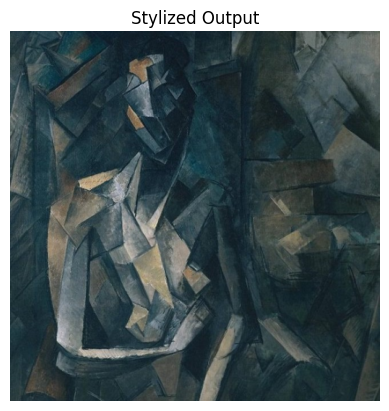

In [10]:
unloader = transforms.ToPILImage()
stylized = input_img.cpu().clone().squeeze(0)
image = unloader(stylized)

plt.imshow(image)
plt.title("Stylized Output")
plt.axis("off")
plt.show()

# Save the result
image.save("stylized_output.png")
